In [ ]:
#sudo apt-get update
#sudo apt-get install -y python3-opencv
#pip install opencv-python

In [12]:
import os
import tensorflow as tf
from PIL import UnidentifiedImageError
from tensorflow.keras.preprocessing.image import (load_img, img_to_array, ImageDataGenerator)
from tensorflow.keras.applications.vgg16 import (preprocess_input, decode_predictions, VGG16)
from tensorflow.keras.layers import (Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
import keras
from keras.callbacks import EarlyStopping

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import (preprocess_input, decode_predictions, VGG16)
from lime import lime_image
from skimage.segmentation import mark_boundaries

import argparse

In [ ]:
def parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--image",
                        "-i",
                        required = False,
                        default = "ADVE/0000136188.jpg",
                        help = "Enter a taget image")               
    args = parser.parse_args()
    return args

In [9]:
def define_model_baseline():
    model = VGG16(include_top = False, pooling = 'avg', input_shape = (224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation = 'relu')(flat1)
    output = Dense(10, activation = 'softmax')(class1)
    model = Model(inputs = model.inputs, outputs = output)
    return model

def define_model_BatchNorm():
    model = VGG16(include_top = False, pooling = 'avg', input_shape = (224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
    bn = BatchNormalization()(flat1)
    class1 = Dense(128, activation='relu')(bn)
    output = Dense(10, activation='softmax')(class1)
    model = Model(inputs = model.inputs, outputs = output)
    return model

In [33]:

def plot_heatmap(filepath):
    folder_name = os.path.dirname(filepath).split('/')[-1]
    image_name = os.path.basename(filepath)

    img = image.load_img(filepath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))

    # Define a function to generate heatmap for a model
    def generate_heatmap(model, ax, title):
        preds = model.predict(x)

        with tf.GradientTape() as tape:
            last_conv_layer = model.get_layer('block5_conv3')  
            iterate = tf.keras.models.Model(model.inputs, [model.output, last_conv_layer.output])
            model_out, last_conv_layer = iterate(x)
            class_out = model_out[:, np.argmax(model_out[0])]
            grads = tape.gradient(class_out,  last_conv_layer)
            pooled_grads = K.mean(grads,axis = (0, 1, 2))

        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis = -1)

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        heatmap = heatmap.reshape((14, 14))  # heatmap.numpy().reshape((14, 14))
        #plt.matshow(heatmap)    

        img_cv = cv2.imread(filepath)
        intensity = 0.6
        heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
        heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        #superimposed_img = (heatmap * intensity) + img_cv
        superimposed_img = cv2.addWeighted(heatmap_resized, intensity, img_cv, 0.4, 0)

        ax.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        ax.set_title(title, fontsize = 10)
        ax.axis('off')


    # Generate heatmaps for baseline and batch normalization models
    baseline_model = define_model_baseline()
    generate_heatmap(baseline_model, axes[0], 'Baseline model')

    batchnorm_model = define_model_BatchNorm()
    generate_heatmap(batchnorm_model, axes[1], 'BatchNorm model')

    plt.suptitle(f'Heatmaps for image {folder_name}/{image_name}', fontsize=16)
    plt.savefig(f'../out/heatmap_{folder_name}{image_name}.png')
    plt.show()

    return print("The plot has been saved to the out folder")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


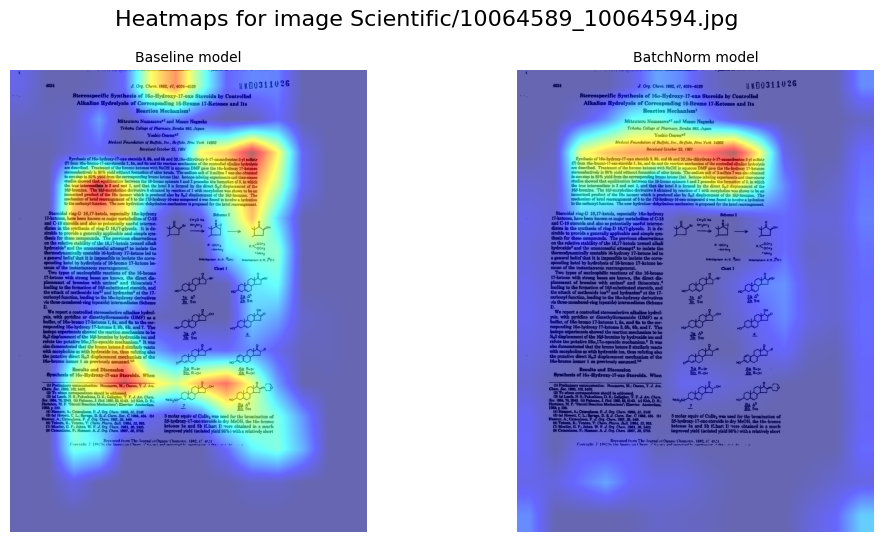

NameError: name 'folder_nameprint' is not defined

In [34]:
def main():

    args = parser()
    plot_heatmap(f'../../../../../cds-vis-data/Tobacco3482/{args.image}')

if __name__ == "__main__":
    main()